In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import VarianceThreshold

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

X = train.drop(columns=['LBDHDD_outcome'])
y = train['LBDHDD_outcome']
X_test = test.copy()

original_cols = set(X.columns)

ids_to_drop = [col for col in X.columns if 'Unnamed: 0' in col.upper() or 'SEQN' in col.upper()]
X = X.drop(columns='Unnamed: 0')
removed_cols = list(original_cols - set(X.columns))

print(f"--- DATA CLEANING: Manual ---")
print(f"Original columns: {len(original_cols)}")
print(f"Remaining columns: {len(X.columns)}")
print(f"removed:")
print(train[removed_cols].head())

selector = VarianceThreshold(threshold=0.0) 
X = pd.DataFrame(selector.fit_transform(X), columns=X.columns[selector.get_support()])

removed_cols = list(original_cols - set(X.columns))

print(f"--- DATA CLEANING: Completely useless columns ---")
print(f"Original columns: {len(original_cols)}")
print(f"Remaining columns: {len(X.columns)}")
print(f"removed:")
print(train[removed_cols].head())

threshold = 0.60
X = X.dropna(thresh=len(X) * threshold, axis=1)

corr_matrix = X.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f"Redundant variables to consider dropping: {to_drop}")

potential_ids = [col for col in X.select_dtypes(include=['object']) 
                 if X[col].nunique() > 500]

print(f"Potential hidden ID columns: {potential_ids}")

--- DATA CLEANING: Manual ---
Original columns: 96
Remaining columns: 95
removed:
   Unnamed: 0
0           1
1           2
2           3
3           4
4           5
--- DATA CLEANING: Completely useless columns ---
Original columns: 96
Remaining columns: 92
removed:
   Unnamed: 0  ALQ111  DRABF  DR1MRESP
0           1       1      2         1
1           2       1      2         1
2           3       1      2         1
3           4       1      2         1
4           5       1      2         1
Redundant variables to consider dropping: ['DR1TFDFE', 'DR1TS060', 'DR1TS140', 'DR1TS160', 'DR1TM181', 'DR1TP182', 'DR1TP225', 'DR1TP226', 'RIDRETH3']
Potential hidden ID columns: []


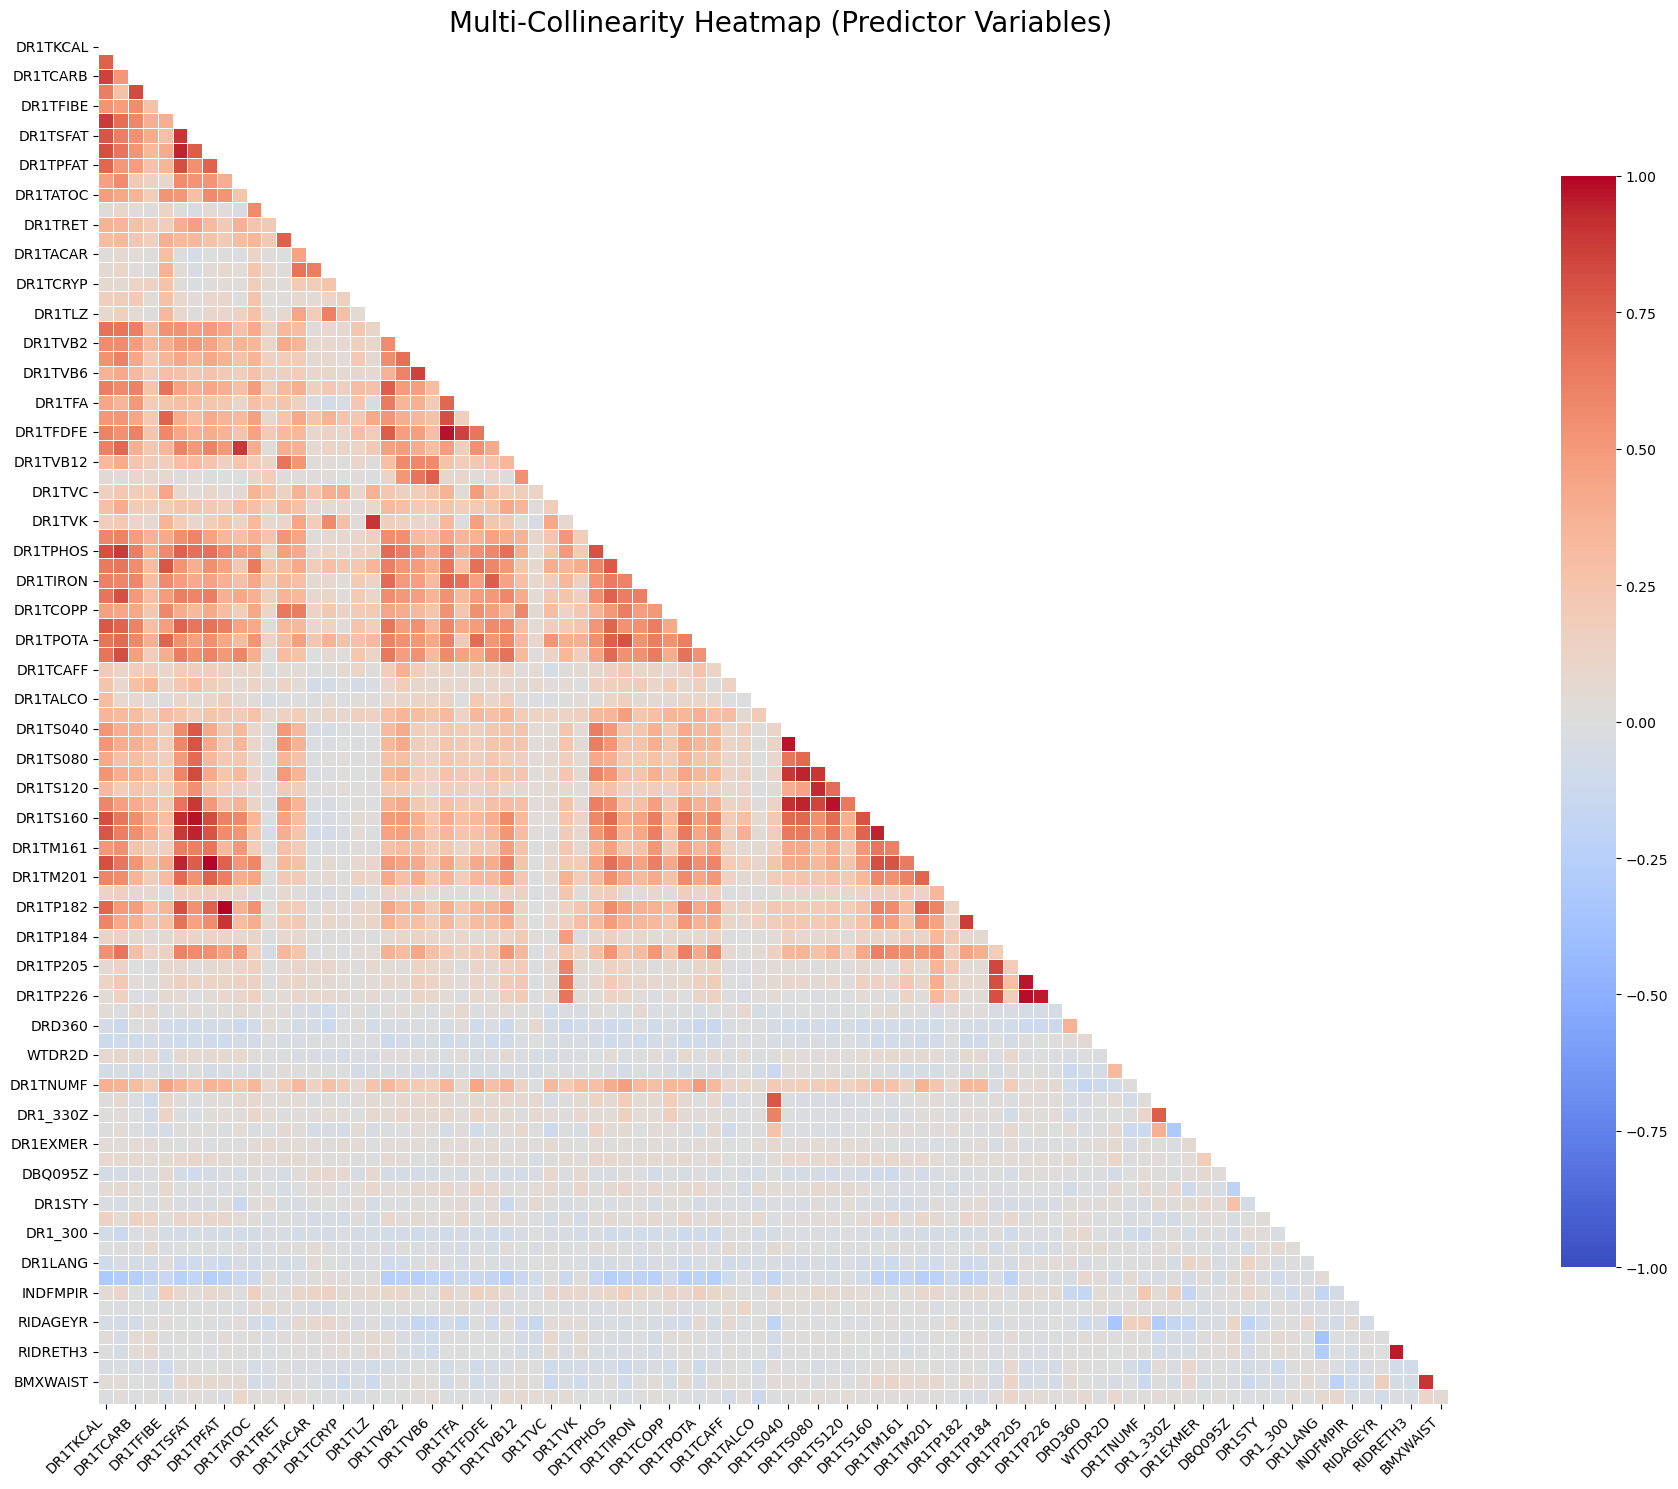

In [ ]:
# X = train.drop(columns=['LBDHDD_outcome'])
# X = X.select_dtypes(include=[np.number])

# # # Remove columns with more than 40% missing values (hard to correlate)
# # X = X.dropna(thresh=len(X) * 0.6, axis=1)

# # # Remove constant columns (zero variance)
# # X = X.loc[:, X.nunique() > 1]

corr_matrix = X.corr()

plt.figure(figsize=(20, 15))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot the heatmap
heatmap = sns.heatmap(
    corr_matrix, 
    mask=mask, 
    annot=False,          
    fmt=".2f", 
    cmap='coolwarm',     
    vmin=-1, vmax=1, 
    center=0,
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .8}
)

plt.title('Multi-Collinearity Heatmap (Predictor Variables)', fontsize=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

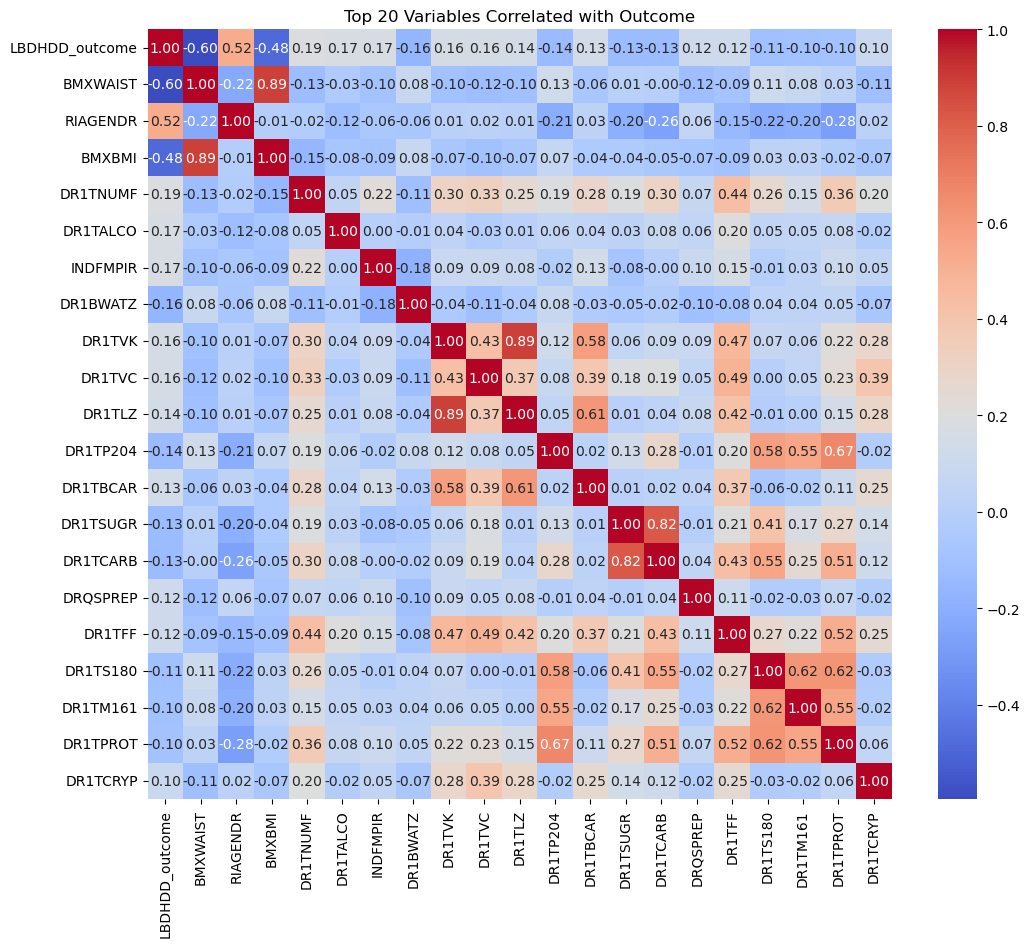

In [ ]:
# Get top 20 variables most correlated with the outcome
top_features = train.corr()['LBDHDD_outcome'].abs().sort_values(ascending=False).head(21).index
top_corr = train[top_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(top_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Top 20 Variables Correlated with Outcome')
plt.show()

In [ ]:
X_test = X_test[X.columns]

removed_cols = list(original_cols - set(X.columns))

print(f"--- DATA CLEANING SUMMARY ---")
print(f"Original columns: {len(original_cols)}")
print(f"Remaining columns: {len(X.columns)}")
print(f"removed:")
print(train[removed_cols].head())


--- DATA CLEANING SUMMARY ---
Original columns: 96
Remaining columns: 92
removed:
   Unnamed: 0  ALQ111  DRABF  DR1MRESP
0           1       1      2         1
1           2       1      2         1
2           3       1      2         1
3           4       1      2         1
4           5       1      2         1


Training

In [ ]:
from xgboost import XGBRegressor
X = X.drop(columns = ['DR1TFDFE', 'DR1TS060', 'DR1TS140', 'DR1TS160', 'DR1TM181', 'DR1TP182', 'DR1TP225', 'DR1TP226', 'RIDRETH3'])
X = X.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(X_test))

xgb_params = {
    'objective': 'reg:squarederror',
    'max_depth': 4,
    'learning_rate': 0.05,
    'n_estimators': 500,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_jobs': -1,
    'random_state': 42
}

for train_idx, val_idx in kf.split(X, y):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
    
    oof_preds[val_idx] = model.predict(X_val)
    # test_preds += model.predict(X_test) / 5

cv_rmse = np.sqrt(mean_squared_error(y, oof_preds))
print(f"Estimated CV RMSE: {cv_rmse:.4f}")

selector_model = XGBRegressor()
selector_model.fit(X, y)

importances = pd.Series(selector_model.feature_importances_, index=X.columns)
useless_features = importances[importances == 0].index.tolist()

print(f"Variables the model ignored completely: {useless_features}")

Estimated CV RMSE: 4.7857
Variables the model ignored completely: []


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [4, 5, 6],
    'learning_rate': [0.003, 0.006, 0.01, 0.015, 0.02],
    'n_estimators': [800, 1000, 1200],
    'subsample': [0.8],         
    'colsample_bytree': [0.8]   
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5, 
    scoring='neg_root_mean_squared_error', 
    verbose=1,
    n_jobs=-1 
)

grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 45 candidates, totalling 225 fits


/opt/anaconda3/envs/ds_env/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/envs/ds_env/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/envs/ds_env/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin t

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.006, 'max_depth': 4, 'n_estimators': 1000, 'subsample': 0.8}
Best RMSE: 4.72212688126686


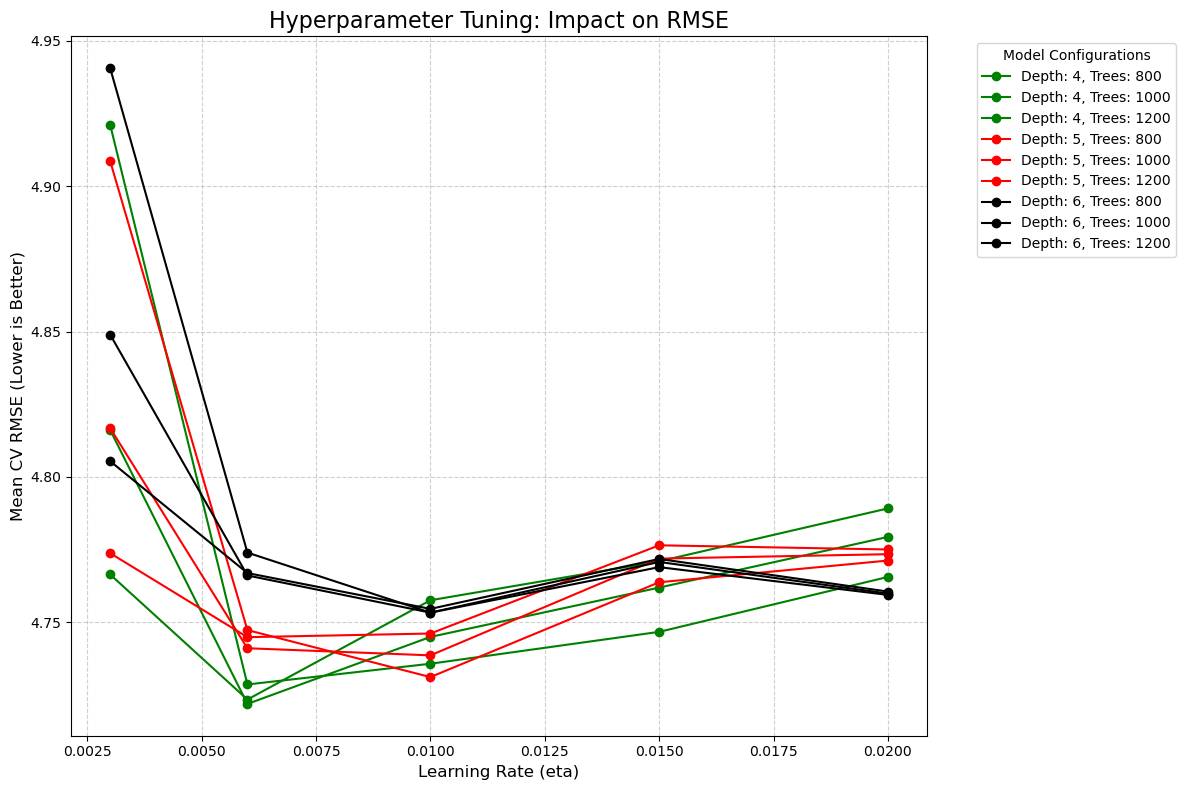

In [ ]:
results = grid_search.cv_results_

l_rates = sorted(list(set(results['param_learning_rate'].data)))
depths = sorted(list(set(results['param_max_depth'].data)))
estimators = sorted(list(set(results['param_n_estimators'].data)))

plt.figure(figsize=(12, 8))

colors = {3: 'blue', 4: 'green', 5: 'red'}
line_styles = {500: '--', 1000: '-'} 

for depth in depths:
    for n_est in estimators:
        rmse_values = []
        for lr in l_rates:
            for score, params in zip(results['mean_test_score'], results['params']):
                if (params['learning_rate'] == lr and 
                    params['max_depth'] == depth and 
                    params['n_estimators'] == n_est):
                    rmse_values.append(-score) 
                    break
        
        label = f'Depth: {depth}, Trees: {n_est}'
        plt.plot(l_rates, rmse_values, marker='o', 
                 color=colors.get(depth, 'black'), 
                 linestyle=line_styles.get(n_est, '-'),
                 label=label)

plt.title('Hyperparameter Tuning: Impact on RMSE', fontsize=16)
plt.xlabel('Learning Rate (eta)', fontsize=12)
plt.ylabel('Mean CV RMSE (Lower is Better)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Model Configurations", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('tuning_results.png', dpi=300)
plt.show()

In [ ]:
len(X.columns)

In [ ]:
X_test = X_test[X.columns]
final_model = xgb.XGBRegressor(**grid_search.best_params_, objective='reg:squarederror', random_state=42)
final_model.fit(X, y)
test_preds = final_model.predict(X_test)

In [ ]:
test_preds_df = pd.DataFrame(test_preds, columns=['LBDHDD_outcome'])
test_preds_df.to_csv("pred.csv", index=False)